In [1]:
import torch
import pandas as pd
import numpy as np
import importlib
import ModelRunner as MR
import MakeDataset as MD
import SiameseNeuralNetwork as SNN
import SimpleNeuralNetwork as SimpNN
from matplotlib import pyplot as plt
from pubchempy import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# Load the dataset. Clean it up by removing missing molecule features. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature
molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

xe = torch.tensor(np.array(eutectic_compilation.xe).astype(float) / 100.0)
eutectic_compilation.xe = xe

In [3]:
# Min-Max Scaler transformation on molecule features
scaler = MinMaxScaler()
# molecule_features.iloc[:, 1:] = scaler.fit_transform(molecule_features.iloc[:, 1:])

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

train_ec.iloc[:, 2:] = scaler.fit_transform(train_ec.iloc[:, 2:])
val_ec.iloc[:, 2:] = scaler.transform(val_ec.iloc[:, 2:])
test_ec.iloc[:, 2:] = scaler.transform(test_ec.iloc[:, 2:])

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
eutectic_compilation

,molA,molB,xe,Te
0,BF3,N2O,0.766,-138.0
1,BF3,SO2,0.952,-128.6
2,BCl3,GeCl4,0.760,-116.0
3,BCl3,PCl3,0.940,-110.0
4,BCl3,PCl3,0.200,-99.0
...,...,...,...,...
4463,Sc2O3,ZrO2,0.522,2450.0
4464,UO2,ZrO2,0.475,2550.0
4465,UO2,ZrO2,0.500,2550.0
4466,UN,W,1.000,2700.0


In [7]:
train_ec

,molA,molB,xe,Te
1803,CsCl,PbCl2,0.560,0.216350
3500,CaF2,KF,0.136,0.323467
1258,CdCl2,PbBr2,0.200,0.168428
2549,CaBr,CsCl,0.585,0.264623
3511,CaMoO4,NaCl,0.975,0.324172
...,...,...,...,...
2222,CoFe2O4,PbF2,0.140,0.244186
376,AlBr3,CsBr,0.790,0.101128
569,BiCl3,CuCl,0.560,0.115574
1068,KF,KNO3,0.090,0.153629


In [8]:
val_ec

,molA,molB,xe,Te
1055,KCl,ZnSO4,0.666,0.152572
3158,GaAs,GaSb,0.030,0.298097
1090,Rb2SO4,RbNO3,0.015,0.154334
544,CsNO3,LiNO3,0.550,0.113108
1297,AgCl,Ag2CrO4,0.596,0.173362
...,...,...,...,...
2277,CsBO2,CsBr,0.475,0.247357
3594,CrF3,CsF,0.390,0.333333
344,FeCl3,NaAlCl4,0.020,0.098661
4129,Nb2O3,WO3,0.400,0.520789


In [9]:
test_ec

,molA,molB,xe,Te
2,BCl3,GeCl4,0.76,0.007752
30,Si2OCl6,TiCl4,0.42,0.031008
36,POCl3,SnCl4,0.05,0.036716
37,SnCl4,WCl6,1.00,0.037350
52,GaCl3,SbCl5,0.18,0.047216
...,...,...,...,...
4395,Cr2O3,Gd2O3,0.23,0.774489
4404,La2O3,ZrO2,0.64,0.781536
4419,Sc2O3,Y2O3,0.55,0.788584
4426,BeO,PuO2,0.66,0.800916


In [10]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [11]:
importlib.reload(MD)

<module 'MakeDataset' from 'D:\\Research\\UConn_ML\\Code\\MakeDataset.py'>

In [12]:
# Using the PubChemPy API to see how to extract molecule features. Get the features of a bunch of random molecules by CID.
import random

molprops = pd.DataFrame()
props = ['MolecularWeight', 'Complexity', 'RotatableBondCount', 'HeavyAtomCount', 'MolecularFormula', 'tpsa']    
names = ['BaO', 'CrCl3', 'PBr5', 'WCl5']

for name in names:
    df = get_properties(props, name, 'formula', as_dataframe=True)
    molprops = molprops.append(df)
molprops

C:\Users\arjun\AppData\Local\Temp\ipykernel_10404\4163515157.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  molprops = molprops.append(df)
C:\Users\arjun\AppData\Local\Temp\ipykernel_10404\4163515157.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  molprops = molprops.append(df)
C:\Users\arjun\AppData\Local\Temp\ipykernel_10404\4163515157.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  molprops = molprops.append(df)
C:\Users\arjun\AppData\Local\Temp\ipykernel_10404\4163515157.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  molprops = molprops.append(df)


,MolecularFormula,MolecularWeight,TPSA,Complexity,RotatableBondCount,HeavyAtomCount
CID,,,,,,
62392,BaO,153.33,17.1,2,0,2
9855530,BaO,153.33,1.0,0,0,2
139046089,BaO,153.33,1.0,2,0,2
24808,Cl3Cr,158.35,0.0,8,0,4
6452300,Cl3Cr,158.35,0.0,0,0,4
66382,Cl3Cr,157.30,0.0,8,0,4
73415767,Cl3Cr,157.30,0.0,0,0,4
22137002,Cl3Cr-,158.35,0.0,0,0,4
4426574,Cl3Cr+,158.35,0.0,8,0,4


In [13]:
# Define parameters and datasets to pass into trainer. Pass in order of definition
starting_features = 5
batchsize = 30
max_epochs = 20
lrbase = 7.5e-5

# For xe
overfit_bound = 0.25
# For Te
# overfit_bound = 0.3

train_dset = MD.MD(train_ec, molecule_features, starting_features)
val_dset = MD.MD(val_ec, molecule_features, starting_features)
test_dset = MD.MD(test_ec, molecule_features, starting_features)

# Set the baselines for training, validation, and testing
# MAE is basically standard deviation, so the baseline is the std of the dataset
# MAE tells us how much + or - pred is from truth on average
train_stdev = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float)))
# train_stdev = torch.std(torch.tensor(np.array(train_ec["Te"]).astype(float)))

train_param = "xe"

In [14]:
importlib.reload(MR)
importlib.reload(SNN)
importlib.reload(SimpNN)
modelrunner = MR.MR(starting_features, batchsize, max_epochs, lrbase, 
                    train_dset, val_dset, test_dset, train_stdev, train_param)

In [24]:
trloss, trbase, vloss, vbase = modelrunner.train_and_validate('siam', overfit_bound)

Epoch 1 | Train Loss: 0.375806 | Train Baseline: 0.294444 | Val Loss: 0.358581 | Val Baseline: 0.289203
Epoch 2 | Train Loss: 0.365698 | Train Baseline: 0.294444 | Val Loss: 0.34991 | Val Baseline: 0.289203
Epoch 3 | Train Loss: 0.356454 | Train Baseline: 0.294444 | Val Loss: 0.339569 | Val Baseline: 0.289203
Epoch 4 | Train Loss: 0.345142 | Train Baseline: 0.294444 | Val Loss: 0.328802 | Val Baseline: 0.289203
Epoch 5 | Train Loss: 0.333478 | Train Baseline: 0.294444 | Val Loss: 0.317601 | Val Baseline: 0.289203
Epoch 6 | Train Loss: 0.320834 | Train Baseline: 0.294444 | Val Loss: 0.304063 | Val Baseline: 0.289203
Epoch 7 | Train Loss: 0.30594 | Train Baseline: 0.294444 | Val Loss: 0.291405 | Val Baseline: 0.289203
Epoch 8 | Train Loss: 0.290382 | Train Baseline: 0.294444 | Val Loss: 0.277174 | Val Baseline: 0.289203
Epoch 9 | Train Loss: 0.274518 | Train Baseline: 0.294444 | Val Loss: 0.262723 | Val Baseline: 0.289203
Epoch 10 | Train Loss: 0.256685 | Train Baseline: 0.294444 | Val L

In [25]:
outputs, invouts, truths, testloss, r2 = modelrunner.test()

C:\Users\arjun\anaconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.256 | Test Baseline: 0.3 | R^2: -0.369



In [26]:
simptrloss, simptrbase, simpvloss, simpvbase = modelrunner.train_and_validate('simp', overfit_bound)

Epoch 1 | Train Loss: 0.469404 | Train Baseline: 0.294444 | Val Loss: 0.465521 | Val Baseline: 0.289203
Epoch 2 | Train Loss: 0.467809 | Train Baseline: 0.294444 | Val Loss: 0.468236 | Val Baseline: 0.289203
Callback to epoch 1 | Patience 1/5
Epoch 3 | Train Loss: 0.467172 | Train Baseline: 0.294444 | Val Loss: 0.466114 | Val Baseline: 0.289203
Callback to epoch 1 | Patience 2/5
Epoch 4 | Train Loss: 0.468213 | Train Baseline: 0.294444 | Val Loss: 0.465226 | Val Baseline: 0.289203
Epoch 5 | Train Loss: 0.466546 | Train Baseline: 0.294444 | Val Loss: 0.466966 | Val Baseline: 0.289203
Callback to epoch 4 | Patience 1/5
Epoch 6 | Train Loss: 0.466441 | Train Baseline: 0.294444 | Val Loss: 0.466947 | Val Baseline: 0.289203
Callback to epoch 4 | Patience 2/5
Epoch 7 | Train Loss: 0.46658 | Train Baseline: 0.294444 | Val Loss: 0.465919 | Val Baseline: 0.289203
Callback to epoch 4 | Patience 3/5
Epoch 8 | Train Loss: 0.466246 | Train Baseline: 0.294444 | Val Loss: 0.46796 | Val Baseline: 0.28

In [27]:
simpoutputs, simpinvouts, simptruths, simptestloss, simpr2 = modelrunner.test()

Test Loss: 0.481 | Test Baseline: 0.3 | R^2: -3.221



C:\Users\arjun\anaconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


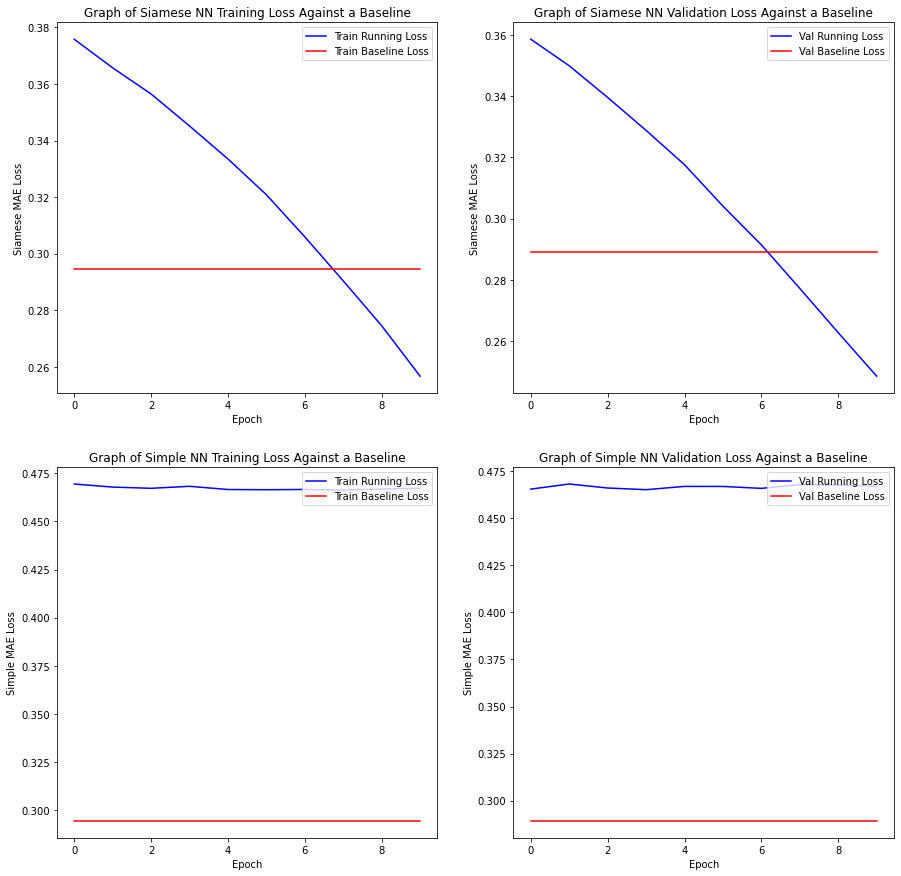

In [28]:
l1 = len(trloss)
l2 = len(simptrloss)
x1 = np.arange(l1)
x2 = np.arange(l2)

lossfig, axes = plt.subplots(2, 2)
lossfig.set_figheight(15)
lossfig.set_figwidth(15)
            
axes[0, 0].plot(x1, trloss[0:l1], label="Train Running Loss", c="blue")
axes[0, 0].plot(x1, trbase[0:l1], label="Train Baseline Loss", c="red")
axes[0, 0].set_title("Graph of Siamese NN Training Loss Against a Baseline")
axes[0, 0].set(xlabel="Epoch", ylabel="Siamese MAE Loss")
axes[0, 0].legend(loc="upper right")

axes[0, 1].plot(x1, vloss[0:l1], label="Val Running Loss", c="blue")
axes[0, 1].plot(x1, vbase[0:l1], label="Val Baseline Loss", c="red")
axes[0, 1].set_title("Graph of Siamese NN Validation Loss Against a Baseline")
axes[0, 1].set(xlabel="Epoch", ylabel="Siamese MAE Loss")
axes[0, 1].legend(loc="upper right")

axes[1, 0].plot(x2, simptrloss[0:l2], label="Train Running Loss", c="blue")
axes[1, 0].plot(x2, simptrbase[0:l2], label="Train Baseline Loss", c="red")
axes[1, 0].set_title("Graph of Simple NN Training Loss Against a Baseline")
axes[1, 0].set(xlabel="Epoch", ylabel="Simple MAE Loss")
axes[1, 0].legend(loc="upper right")

axes[1, 1].plot(x2, simpvloss[0:l2], label="Val Running Loss", c="blue")
axes[1, 1].plot(x2, simpvbase[0:l2], label="Val Baseline Loss", c="red")
axes[1, 1].set_title("Graph of Simple NN Validation Loss Against a Baseline")
axes[1, 1].set(xlabel="Epoch", ylabel="Simple MAE Loss")
axes[1, 1].legend(loc="upper right")

plt.show()

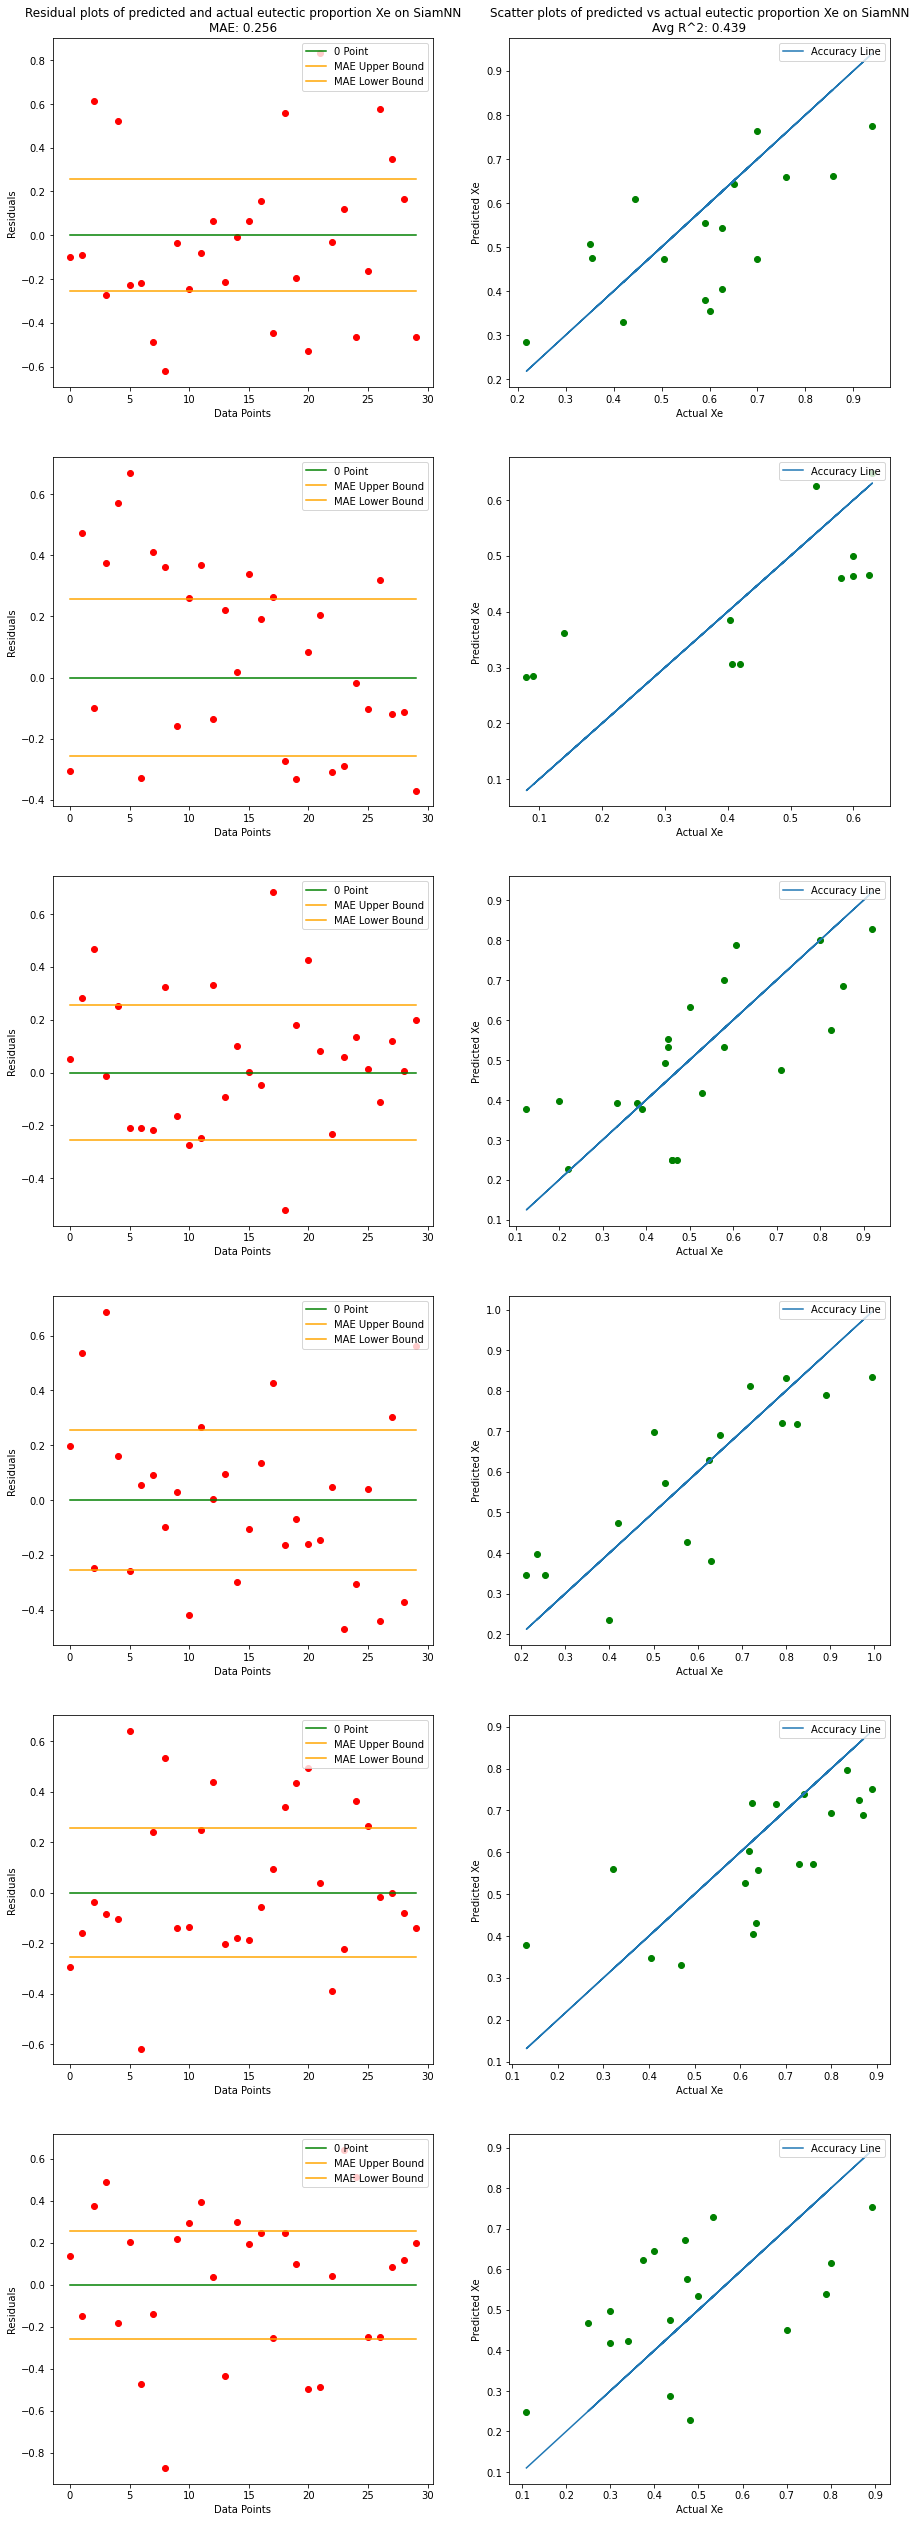

In [29]:
l = batchsize
numplots = int(len(outputs) / l)
siamfig, axes = plt.subplots(numplots, 2)
siamfig.set_figheight(45)
siamfig.set_figwidth(15)

pred = 0
succ = 1
x = np.arange(l)
mae = np.round(testloss, 3)
r2 = 0
        
for row in range(numplots):
    reduced_outputs = np.array([])
    reduced_truths = np.array([])

    outbatch = outputs[pred*l:succ*l]
    trubatch = truths[pred*l:succ*l]
    
    for out in range(len(outbatch)):
        if np.abs(outbatch[out] - trubatch[out]) < testloss:
            reduced_outputs = np.append(reduced_outputs, outbatch[out])
            reduced_truths = np.append(reduced_truths, trubatch[out])
        
    axes[row, 0].scatter(x, outputs[pred*l:succ*l] - truths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].plot(x, np.full((l,), mae), c="orange", label="MAE Upper Bound")
    axes[row, 0].plot(x, np.full((l,), -1*mae), c="orange", label="MAE Lower Bound")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(reduced_truths, reduced_outputs, c="green")
    axes[row, 1].plot(reduced_truths, reduced_truths, label="Accuracy Line")
    
    if train_param == "xe":
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    else:
        axes[row, 1].set(xlabel="Actual Te", ylabel="Predicted Te")

    axes[row, 1].legend(loc="upper right")
    r2 += r2_score(reduced_truths, reduced_outputs) / numplots
            
    pred += 1
    succ += 1

r2 = np.round(r2, 3)
if train_param == "xe":
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic proportion Xe on SiamNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic proportion Xe on SiamNN\nAvg R^2: {}".format(r2))
else: 
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic temperature Te on SiamNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic temperature Te on SiamNN\nAvg R^2 {}".format(r2))

plt.show()

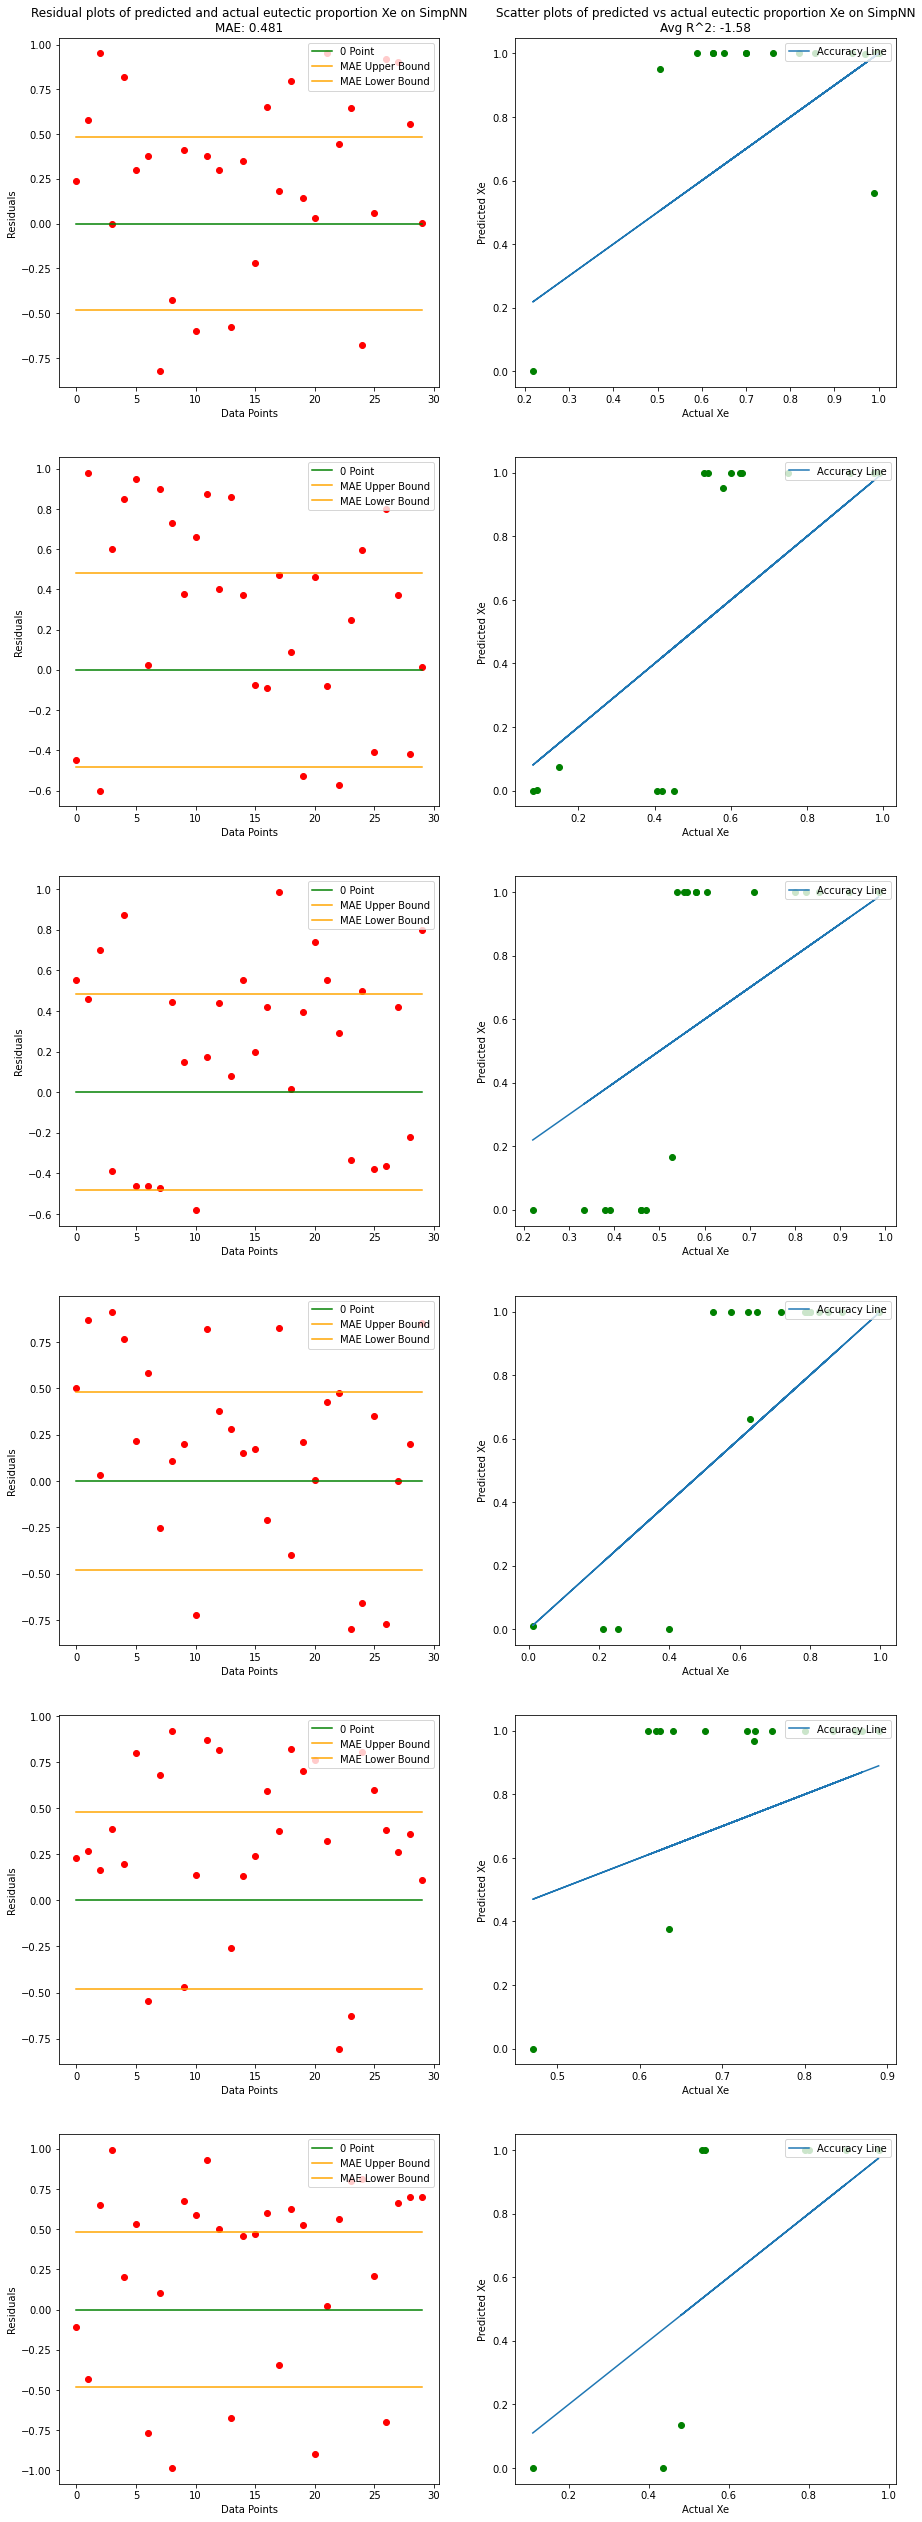

In [30]:
l = batchsize
numplots = int(len(simpoutputs) / l)
simpfig, axes = plt.subplots(numplots, 2)
simpfig.set_figheight(45)
simpfig.set_figwidth(15)

pred = 0
succ = 1
x = np.arange(l)
mae = np.round(simptestloss, 3)
r2 = 0
        
for row in range(numplots):
    simp_reduced_outputs = np.array([])
    simp_reduced_truths = np.array([])

    outbatch = simpoutputs[pred*l:succ*l]
    trubatch = simptruths[pred*l:succ*l]
    
    for out in range(len(outbatch)):
        if np.abs(outbatch[out] - trubatch[out]) < simptestloss:
            simp_reduced_outputs = np.append(simp_reduced_outputs, outbatch[out])
            simp_reduced_truths = np.append(simp_reduced_truths, trubatch[out])
        
    axes[row, 0].scatter(x, simpoutputs[pred*l:succ*l] - simptruths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].plot(x, np.full((l,), mae), c="orange", label="MAE Upper Bound")
    axes[row, 0].plot(x, np.full((l,), -1*mae), c="orange", label="MAE Lower Bound")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(simp_reduced_truths, simp_reduced_outputs, c="green")
    axes[row, 1].plot(simp_reduced_truths, simp_reduced_truths, label="Accuracy Line")
    
    if train_param == "xe":
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    else:
        axes[row, 1].set(xlabel="Actual Te", ylabel="Predicted Te")

    axes[row, 1].legend(loc="upper right")
    r2 += r2_score(simp_reduced_truths, simp_reduced_outputs) / numplots
            
    pred += 1
    succ += 1

r2 = np.round(r2, 3)
if train_param == "xe":
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic proportion Xe on SimpNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic proportion Xe on SimpNN\nAvg R^2: {}".format(r2))
else:
    axes[0, 0].set_title(
        "Residual plots of predicted and actual eutectic temperature Te on SimpNN\nMAE: {}".format(mae))
    axes[0, 1].set_title(
        "Scatter plots of predicted vs actual eutectic temperature Te on SimpNN\nAvg R^2: {}".format(r2))

plt.show()

In [31]:
# Print the values from the last batch processed just for the user to see
if train_param == "xe":
    disp = pd.DataFrame({
        'f(A,B) + f(B,A)': outputs + invouts,
        'Truth': np.round(truths, 3),
        'Siamese Pred': np.round(outputs, 3),
        'Simple Pred': np.round(simpoutputs, 3)
    })
else:
    disp = pd.DataFrame({
        'Truth': np.round(truths, 3),
        'Siamese Pred': np.round(outputs, 3), 
        'Simple Pred': np.round(simpoutputs, 3)
    })
        
disp.style.set_properties(**{'width': '150px'})

,"f(A,B) + f(B,A)",Truth,Siamese Pred,Simple Pred
0,1.000000,0.760000,0.659000,1.000000
1,1.000000,0.420000,0.329000,1.000000
2,1.000000,0.050000,0.663000,1.000000
3,1.000000,1.000000,0.728000,1.000000
4,1.000000,0.180000,0.704000,1.000000
5,1.000000,0.700000,0.474000,1.000000
6,1.000000,0.625000,0.406000,1.000000
7,1.000000,0.825000,0.339000,0.001000
8,1.000000,0.988000,0.368000,0.562000
9,1.000000,0.590000,0.554000,1.000000


In [32]:
# lossfig.savefig('D:\\Research\\UConn_ML\\Plots\\Lossplots_8_4_22.png')
# siamfig.savefig('D:\\Research\\UConn_ML\\Plots\\SiamNNplots_8_4_22.png')
# simpfig.savefig('D:\\Research\\UConn_ML\\Plots\\SimpNNplots_8_4_22.png')